In [61]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/tabular-playground-series-nov-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-nov-2021/train.csv
/kaggle/input/tabular-playground-series-nov-2021/test.csv


In [62]:
import os
import wandb
from wandb.keras import WandbCallback
os.system('! wandb login be213aaff4ff14945d480abc18697d8664bba8c8')
training = pd.read_csv('/kaggle/input/tabular-playground-series-nov-2021/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-nov-2021/test.csv')
test['target'] = np.NaN
training['train_test'] = 1
test['train_test'] = 0
all_data = pd.concat([training,test]) 

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
attribute_names = all_data.columns.tolist()
test_atts = test.columns.tolist()
all_dummies = pd.get_dummies(all_data[attribute_names])
test_dummies = pd.get_dummies(test[test_atts])  
X_train = all_dummies[all_data.train_test == 1].drop(['train_test'], axis=1)
for column in X_train.columns:
    mean_value = X_train[column].mean()
    X_train[column].fillna(mean_value, inplace=True)
X_check = X_train #for heatmap
X_train = X_train.drop(['target'], axis=1)
X_backup = X_train
X_test = all_dummies[all_data.train_test == 0].drop(['train_test'], axis=1)
y_train = all_data[all_data.train_test==1].target
y_backup = y_train
X_test = X_test.drop(['target'], axis=1)
for column in X_test.columns:
    mean_value = X_test[column].mean()
    X_test[column].fillna(mean_value, inplace=True)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [63]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
X_adapt = X_train.drop(['id'], axis=1)
all_attributes =X_adapt.columns.tolist()
columns_to_normalize = all_attributes
scaler = MinMaxScaler()
X_train_scaled = X_train
X_train_scaled[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])
#X_train_scaled = X_train_scaled[:,~np.all(np.isnan(d), axis=0)]
X_test_scaled = X_test
X_test_scaled[columns_to_normalize] = scaler.fit_transform(X_test[columns_to_normalize])

#also norm. backup
X_backup[columns_to_normalize] = scaler.fit_transform(X_backup[columns_to_normalize])

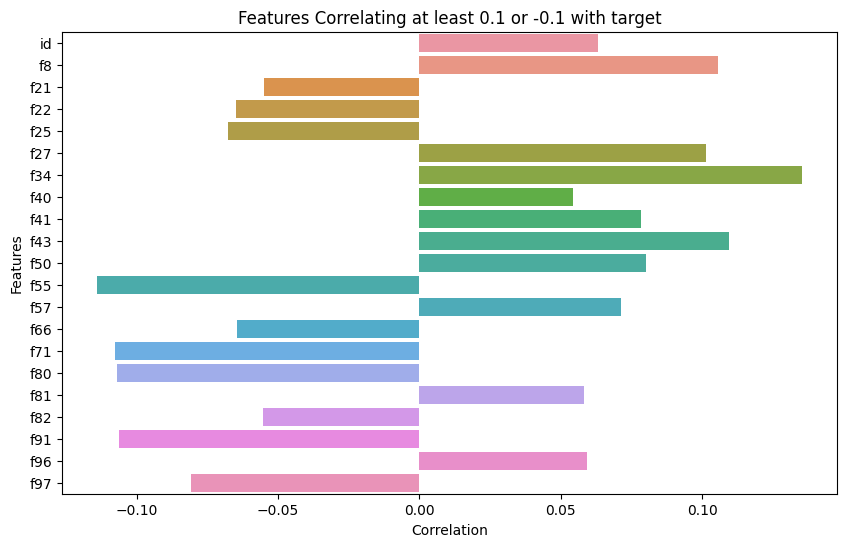

            id        f8       f21       f22       f25       f27       f34  \
0            0  0.437860  0.563108  0.603621  0.585179  0.383577  0.668653   
1            1  0.758411  0.232495  0.506902  0.809956  0.347932  0.226292   
2            2  0.398849  0.384706  0.384251  0.329170  0.398059  0.125291   
3            3  0.752827  0.336273  0.379931  0.260065  0.372626  0.689068   
4            4  0.604515  0.384371  0.463156  0.757921  0.376516  0.607420   
...        ...       ...       ...       ...       ...       ...       ...   
599995  599995  0.360000  0.279723  0.414108  0.469714  0.376446  0.148985   
599996  599996  0.277418  0.261890  0.581748  0.251450  0.388653  0.456161   
599997  599997  0.300987  0.295712  0.681341  0.532694  0.375381  0.318810   
599998  599998  0.421029  0.297240  0.353364  0.131150  0.397159  0.279071   
599999  599999  0.318868  0.192555  0.767225  0.626231  0.391909  0.788113   

             f40       f41       f43  ...       f55       f57  

In [64]:
target_column = 'target'

# Calculate the correlations between the target and all features
correlations = training.corr()[target_column]
correlations = correlations.drop('target')
# Filter features with a correlation of at least 0.4 or -0.4
significant_features = correlations[(correlations >= 0.05) | (correlations <= -0.05)]
significant_features_index = correlations[(correlations >= 0.05) | (correlations <= -0.05)].index

# Visualize the correlation values
plt.figure(figsize=(10, 6))
sns.barplot(x=significant_features.values, y=significant_features.index)
plt.title(f'Features Correlating at least 0.1 or -0.1 with {target_column}')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.show()
X_train_sig = X_train_scaled[significant_features_index]
X_test_sig = X_test_scaled[significant_features_index]
print(X_train_sig)

In [65]:
from sklearn.model_selection import train_test_split
num_samples = int(len(X_train_sig) * 0.1)
random_indices = np.random.choice(len(X_train_sig), num_samples, replace=False)
X_subset = X_train_sig.iloc[random_indices]
y_subset = y_train.iloc[random_indices]
#X_train = X_train_sig
X_train, X_val, y_train, y_val = train_test_split(X_subset, y_subset, test_size=0.2, random_state=1)

In [66]:
print(X_train)

            id        f8       f21       f22       f25       f27       f34  \
209629  209629  0.765909  0.276596  0.614805  0.474091  0.375118  0.227152   
557431  557431  0.378983  0.265025  0.610152  0.114939  0.402982  0.710998   
210733  210733  0.526993  0.325801  0.672326  0.664276  0.386823  0.452119   
434662  434662  0.322913  0.430717  0.378603  0.637153  0.378467  0.215769   
316243  316243  0.629613  0.383141  0.780025  0.424268  0.397209  0.523106   
...        ...       ...       ...       ...       ...       ...       ...   
145402  145402  0.696137  0.275724  0.377268  0.455579  0.408673  0.603016   
50583    50583  0.251566  0.397207  0.330693  0.413492  0.367382  0.148639   
66849    66849  0.898671  0.250125  0.730047  0.581977  0.408085  0.463853   
327304  327304  0.788770  0.246353  0.827696  0.099786  0.405521  0.752235   
17134    17134  0.811157  0.321980  0.660300  0.355957  0.411984  0.282217   

             f40       f41       f43  ...       f55       f57  

In [67]:
import datetime

# Get the current date and time
current_time = datetime.datetime.now()

# Convert the current time to a string with a specific format
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")

# Create a string with the formatted time
time = f"{formatted_time}"

In [68]:
!pip install scikit-learn


import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import wandb

'''def create_neural_network():
    model = MLPClassifier(
        hidden_layer_sizes=(100,),
        max_iter=200,
        alpha=1e-4,
        solver='adam',
        activation='relu',
        learning_rate_init=0.001,
        random_state=1
    )
    return model

wandb.init(project='KaggleNovemer2021NN', name='different NN'+time)

# Define hyperparameters
model = create_neural_network()

model.fit(X_train, y_train)

# Log the model's performance
wandb.log({"accuracy": model.score(X_val, y_val)})

# Finish the run
wandb.finish()'''

'def create_neural_network():\n    model = MLPClassifier(\n        hidden_layer_sizes=(100,),\n        max_iter=200,\n        alpha=1e-4,\n        solver=\'adam\',\n        activation=\'relu\',\n        learning_rate_init=0.001,\n        random_state=1\n    )\n    return model\n\nwandb.init(project=\'KaggleNovemer2021NN\', name=\'different NN\'+time)\n\n# Define hyperparameters\nmodel = create_neural_network()\n\nmodel.fit(X_train, y_train)\n\n# Log the model\'s performance\nwandb.log({"accuracy": model.score(X_val, y_val)})\n\n# Finish the run\nwandb.finish()'

In [69]:
wandb.init(project='KaggleNovemer2021NN', name='NN HPO '+time)
param_grid = {
    'hidden_layer_sizes': [(100,), (150,), (200,)],
    'max_iter': [300, 500, 400],
    'alpha': [1e-3, 1e-4, 1e-5],
    'solver': ['adam'],  
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01, 0.005]
}
'''def create_neural_network():
    model = MLPClassifier(
        hidden_layer_sizes=(100,),
        max_iter=200,
        alpha=1e-4,
        solver='adam',
        activation='relu',
        learning_rate_init=0.001,
        random_state=1
    )
    return model'''

# Create the neural network model
model = MLPClassifier(random_state=1)

# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Log the best hyperparameters and corresponding accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_
wandb.config.update(best_params)
wandb.log({"best_accuracy": best_accuracy})

# Fit the model with the best hyperparameters
best_model = MLPClassifier(**best_params, random_state=1)
best_model.fit(X_train, y_train)

# Log the model's performance on the test set
test_accuracy = best_model.score(X_val, y_val)
wandb.log({"test_accuracy": test_accuracy})

# Finish the run
wandb.finish()

best_accuracy,▁
test_accuracy,▁
best_accuracy,0.52702
test_accuracy,0.50375
